In [98]:
import numpy as np
import pywt
import cv2   

In [99]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [100]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [101]:
import os
img_dirs = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [102]:
img_dirs

['./dataset/cropped/andreas_christensen',
 './dataset/cropped/jules_kounde',
 './dataset/cropped/marc_andre_ter_stegen',
 './dataset/cropped/robert_lewandowski',
 './dataset/cropped/sergio_busquets']

In [103]:
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
            celebrity_file_names_dict[celebrity_name].append(entry.path)
            

In [104]:
celebrity_file_names_dict

{'andreas_christensen': ['./dataset/cropped/andreas_christensen\\andreas_christensen1.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen10.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen11.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen12.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen13.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen14.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen15.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen16.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen17.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen18.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen19.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen2.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen20.png',
  './dataset/cropped/andreas_christensen\\andreas_christensen21.png',

In [105]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'andreas_christensen': 0,
 'jules_kounde': 1,
 'marc_andre_ter_stegen': 2,
 'robert_lewandowski': 3,
 'sergio_busquets': 4}

In [106]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [107]:
y[0]

0

In [108]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(260, 4096)

In [109]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8307692307692308

In [111]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.92      0.92      0.92        13
           2       0.92      0.73      0.81        15
           3       0.92      0.71      0.80        17
           4       0.64      0.90      0.75        10

    accuracy                           0.83        65
   macro avg       0.83      0.85      0.83        65
weighted avg       0.85      0.83      0.83        65



In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [113]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [114]:

scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


,model,best_score,best_params
0,svm,0.774359,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.620513,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.820513,{'logisticregression__C': 5}


In [115]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [116]:
best_estimators['svm'].score(X_test,y_test)

0.8461538461538461

In [118]:
best_estimators['random_forest'].score(X_test,y_test)

0.6

In [119]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8615384615384616

In [120]:
best_clf = best_estimators['logistic_regression']

In [121]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 9,  0,  0,  0,  1],
       [ 0, 11,  1,  0,  1],
       [ 0,  0, 14,  0,  1],
       [ 2,  1,  0, 12,  2],
       [ 0,  0,  0,  0, 10]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

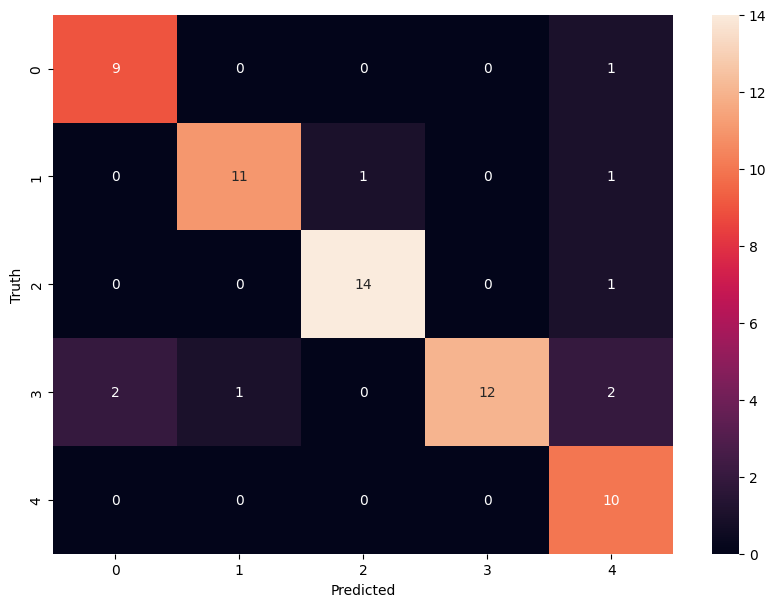

In [124]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [125]:
class_dict

{'andreas_christensen': 0,
 'jules_kounde': 1,
 'marc_andre_ter_stegen': 2,
 'robert_lewandowski': 3,
 'sergio_busquets': 4}

In [126]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [127]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))